In [1]:
# List all device
from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [2]:
# Check available GPU
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  

In [4]:
# Importing the libraries
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Reshape, Lambda, GRU, BatchNormalization, Bidirectional
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.activations import softmax
from keras.optimizers import SGD, RMSprop
import math
import pickle
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

In [5]:
def calculate_class(returns):
    """Find the class for each LSTM sequence based on the median returns."""
    median_returns = returns.median(axis=1)
    labels = returns.iloc[:, :].apply(lambda x: np.where
                                      (x >= median_returns, 1, 0), axis=0)
    return labels

In [6]:
np.random.seed(2)
x_train = np.random.rand(10,2)
x_train.shape

(10, 2)

In [7]:
y_train = to_categorical(calculate_class(pd.DataFrame(x_train)).values, 2)
y_train.shape

(10, 2, 2)

In [8]:
x_train[0]

array([0.4359949 , 0.02592623])

In [9]:
y_train[0]

array([[0., 1.],
       [1., 0.]], dtype=float32)

In [10]:
timestep = 1

In [11]:
x_series = [x_train[i:i+timestep, :] for i in range(1, x_train.shape[0] - timestep)]
y_series = [y_train[i+timestep] for i in range(y_train.shape[0] - timestep - 1)]
x = np.array(x_series)
y = np.array(y_series)
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

x shape: (8, 1, 2)
y shape: (8, 2, 2)


In [12]:
x_train1 = x_train[:-1]
x_train1

array([[0.4359949 , 0.02592623],
       [0.54966248, 0.43532239],
       [0.4203678 , 0.33033482],
       [0.20464863, 0.61927097],
       [0.29965467, 0.26682728],
       [0.62113383, 0.52914209],
       [0.13457995, 0.51357812],
       [0.18443987, 0.78533515],
       [0.85397529, 0.49423684]])

In [13]:
x_train

array([[0.4359949 , 0.02592623],
       [0.54966248, 0.43532239],
       [0.4203678 , 0.33033482],
       [0.20464863, 0.61927097],
       [0.29965467, 0.26682728],
       [0.62113383, 0.52914209],
       [0.13457995, 0.51357812],
       [0.18443987, 0.78533515],
       [0.85397529, 0.49423684],
       [0.84656149, 0.07964548]])

In [14]:
y_train1 = y_train[1:]

In [15]:
train_gen = TimeseriesGenerator(x_train1, y_train1,
                                length=timestep, sampling_rate=1,
                                batch_size=2)

In [16]:
for i in range(train_gen[0][0].shape[0]):
    print(train_gen[0][0][i], train_gen[0][1][i])

[[0.4359949  0.02592623]] [[0. 1.]
 [1. 0.]]
[[0.54966248 0.43532239]] [[1. 0.]
 [0. 1.]]


In [17]:
train_gen[0][1].shape

(2, 2, 2)

In [18]:
regressor = Sequential()
regressor.add(LSTM(units=10, input_shape=(timestep, 2)))
# regressor.add(LSTM(units=10, input_shape=(timestep, 2)))
regressor.add(Dense(4, activation='relu'))
regressor.add(Reshape((2, 2)))
regressor.add(Lambda(lambda x: softmax(x, axis=-1)))
# regressor.add(Dense(2, activation='softmax'))
regressor.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                520       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 44        
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2)              0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 2, 2)              0         
Total params: 564
Trainable params: 564
Non-trainable params: 0
_________________________________________________________________


In [19]:
# result = regressor.fit_generator(train_gen, steps_per_epoch=len(train_gen), epochs=1000)
result = regressor.fit(x, y, steps_per_epoch=len(train_gen), epochs=2000)

Epoch 1/2000
4/4 [==============================] - 1s 140ms/step - loss: 0.6921 - acc: 0.4766
Epoch 2/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.6915 - acc: 0.5078
Epoch 3/2000
4/4 [==============================] - 0s 5ms/step - loss: 0.6905 - acc: 0.6250
Epoch 4/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.6875 - acc: 0.7500
Epoch 5/2000
4/4 [==============================] - 0s 5ms/step - loss: 0.6861 - acc: 0.7500
Epoch 6/2000
4/4 [==============================] - 0s 5ms/step - loss: 0.6853 - acc: 0.7500
Epoch 7/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.6844 - acc: 0.7500
Epoch 8/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.6836 - acc: 0.7344
Epoch 9/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.6827 - acc: 0.6719
Epoch 10/2000
4/4 [==============================] - 0s 5ms/step - loss: 0.6819 - acc: 0.6406
Epoch 11/2000
4/4 [==============================] - 0s 5ms/step - 

4/4 [==============================] - 0s 4ms/step - loss: 0.2972 - acc: 0.8438
Epoch 175/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.2946 - acc: 0.8516
Epoch 176/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.2921 - acc: 0.8516
Epoch 177/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.2896 - acc: 0.8594
Epoch 178/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.2872 - acc: 0.8516
Epoch 179/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.2848 - acc: 0.8594
Epoch 180/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.2824 - acc: 0.8594
Epoch 181/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.2800 - acc: 0.8594
Epoch 182/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.2777 - acc: 0.8672
Epoch 183/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.2753 - acc: 0.8594
Epoch 184/2000
4/4 [==============================] - 0s 4ms/step

4/4 [==============================] - 0s 5ms/step - loss: 0.1340 - acc: 0.9062
Epoch 347/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1339 - acc: 0.8984
Epoch 348/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1339 - acc: 0.9062
Epoch 349/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1338 - acc: 0.9062
Epoch 350/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1337 - acc: 0.9062
Epoch 351/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.1336 - acc: 0.9062
Epoch 352/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.1335 - acc: 0.9062
Epoch 353/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1334 - acc: 0.9062
Epoch 354/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1333 - acc: 0.8984
Epoch 355/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1333 - acc: 0.9062
Epoch 356/2000
4/4 [==============================] - 0s 4ms/step

4/4 [==============================] - 0s 4ms/step - loss: 0.1302 - acc: 0.9062
Epoch 519/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1302 - acc: 0.9062
Epoch 520/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1302 - acc: 0.9062
Epoch 521/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1302 - acc: 0.9062
Epoch 522/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1302 - acc: 0.8984
Epoch 523/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1302 - acc: 0.9062
Epoch 524/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1302 - acc: 0.9062
Epoch 525/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.1302 - acc: 0.9062
Epoch 526/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1302 - acc: 0.9062
Epoch 527/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1302 - acc: 0.9062
Epoch 528/2000
4/4 [==============================] - 0s 4ms/step

4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 691/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 692/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 693/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.1300 - acc: 0.9062
Epoch 694/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.1300 - acc: 0.9062
Epoch 695/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 696/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 697/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.1300 - acc: 0.9062
Epoch 698/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 699/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 700/2000
4/4 [==============================] - 0s 3ms/step

4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 863/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 864/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 865/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 866/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 867/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 868/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 869/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 870/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 871/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 872/2000
4/4 [==============================] - 0s 3ms/step

Epoch 948/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 949/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 950/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 951/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 952/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 953/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 954/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 955/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 956/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 957/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 958/2000
4/4 [==============================

4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1119/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1120/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1121/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1122/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1123/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1124/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1125/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1126/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1127/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1128/2000
4/4 [==============================] - 0

4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1204/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1205/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1206/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1207/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1208/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1209/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1210/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1211/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1212/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1213/2000
4/4 [==============================] - 0

4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1374/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1375/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.8984
Epoch 1376/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1377/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1378/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1379/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1380/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1381/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1382/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1383/2000
4/4 [==============================] - 0

4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1544/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1545/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1546/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1547/2000
4/4 [==============================] - 0s 5ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1548/2000
4/4 [==============================] - 0s 5ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1549/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1550/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1551/2000
4/4 [==============================] - 0s 5ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1552/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1553/2000
4/4 [==============================] - 0

4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1714/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.8984
Epoch 1715/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1716/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1717/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1718/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1719/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1720/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1721/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1722/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1723/2000
4/4 [==============================] - 0

4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1799/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1800/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1801/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1802/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1803/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1804/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1805/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1806/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1807/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1808/2000
4/4 [==============================] - 0

4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1969/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1970/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1971/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1972/2000
4/4 [==============================] - 0s 5ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1973/2000
4/4 [==============================] - 0s 5ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1974/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1975/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1976/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.8984
Epoch 1977/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 1978/2000
4/4 [==============================] - 0

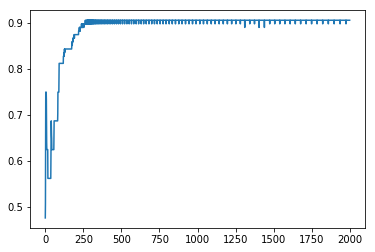

In [20]:
plt.plot(result.history["acc"])

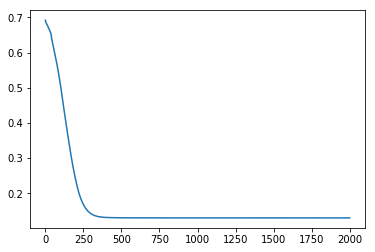

In [21]:
plt.plot(result.history["loss"])

In [31]:
# regressor.predict_generator(train_gen)
regressor.predict(x)

array([[[1.3933036e-09, 1.0000000e+00],
        [9.9999917e-01, 8.0486075e-07]],

       [[6.8737300e-09, 1.0000000e+00],
        [9.9999774e-01, 2.2249712e-06]],

       [[9.9999976e-01, 1.7935075e-07],
        [5.0000000e-01, 5.0000000e-01]],

       [[9.8922293e-08, 9.9999988e-01],
        [9.9998748e-01, 1.2544702e-05]],

       [[1.0954725e-09, 1.0000000e+00],
        [9.9999928e-01, 7.1721661e-07]],

       [[9.9999976e-01, 1.9933914e-07],
        [5.0000000e-01, 5.0000000e-01]],

       [[1.0000000e+00, 9.0778030e-10],
        [5.0000000e-01, 5.0000000e-01]],

       [[3.4964000e-11, 1.0000000e+00],
        [9.9999988e-01, 6.0212756e-08]]], dtype=float32)

In [23]:
y_train[1:]

array([[[0., 1.],
        [1., 0.]],

       [[0., 1.],
        [1., 0.]],

       [[1., 0.],
        [0., 1.]],

       [[0., 1.],
        [1., 0.]],

       [[0., 1.],
        [1., 0.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[0., 1.],
        [1., 0.]],

       [[0., 1.],
        [1., 0.]]], dtype=float32)

In [24]:
x_train.shape

(10, 2)

In [25]:
y_train.shape

(10, 2, 2)

In [26]:
x.shape

(8, 1, 2)

In [27]:
x

array([[[0.54966248, 0.43532239]],

       [[0.4203678 , 0.33033482]],

       [[0.20464863, 0.61927097]],

       [[0.29965467, 0.26682728]],

       [[0.62113383, 0.52914209]],

       [[0.13457995, 0.51357812]],

       [[0.18443987, 0.78533515]],

       [[0.85397529, 0.49423684]]])

In [28]:
y

array([[[0., 1.],
        [1., 0.]],

       [[0., 1.],
        [1., 0.]],

       [[1., 0.],
        [0., 1.]],

       [[0., 1.],
        [1., 0.]],

       [[0., 1.],
        [1., 0.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[0., 1.],
        [1., 0.]]], dtype=float32)

In [38]:
regressor2 = Sequential()
regressor2.add(Dense(10, input_shape=(1, 2)))
regressor2.add(Dense(4, activation='relu'))
regressor2.add(Reshape((2, 2)))
regressor2.add(Lambda(lambda x: softmax(x, axis=-1)))
regressor2.add(Dense(2, activation='softmax'))
regressor2.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
regressor2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1, 10)             30        
_________________________________________________________________
dense_14 (Dense)             (None, 1, 2)              22        
Total params: 52
Trainable params: 52
Non-trainable params: 0
_________________________________________________________________


In [39]:
# regressor2.predict_generator(train_gen)
regressor2.fit(x, y, epochs=2000, batch_size=2)
# regressor2.fit(x_train, y_train, epochs=100, batch_size=2)

ValueError: Error when checking target: expected dense_14 to have shape (1, 2) but got array with shape (2, 2)